<a href="https://colab.research.google.com/github/dkanh6/Machine_Learning_Examples/blob/main/HW12part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First I am going to get the data into this python notebook

In [1]:
from google.colab import files
uploaded = files.upload()

import h5py
import numpy as np

# Initialize data structures for LFP recordings and segment counts
lfp = {'NREM': [], 'WAKE': []}
segment_counts = {'NREM': 0, 'WAKE': 0}

# Loop over each uploaded file
for filename in uploaded.keys():
    print(f'Processing file "{filename}" with length {len(uploaded[filename])} bytes')
    with h5py.File(filename, 'r') as f:  # Open the file
        # Assuming 'fs' is a global attribute for sampling frequency
        fs = f.attrs['fs'][0]
        print(f"Sampling rate: {fs:.1f} Hz")

        # Loop over states in each file
        for state in f.keys():
            group = f[state]  # Access the group corresponding to the state
            segment_ids = list(group.keys())  # List segment IDs within the state

            # Update the count of segments for the state
            segment_counts[state] += len(segment_ids)

            # Extract and store segment data from each file
            for segment_id in segment_ids:
                segment_data = np.array(group[segment_id]).astype(float)
                lfp[state].append(segment_data)

# Print the total number of segments for each state
for state, count in segment_counts.items():
    print(f"Total segments for state '{state}': {count}")


Saving Part1SubjectHB10.h5 to Part1SubjectHB10.h5
Processing file "Part1SubjectHB10.h5" with length 9109466 bytes
Sampling rate: 1000.0 Hz
Total segments for state 'NREM': 17
Total segments for state 'WAKE': 38


In [2]:
import h5py
import numpy as np

# Open the HDF5 file (which act as containers with folders inside that contain two separate objects that have datasets inside them)
filepath = next(iter(uploaded))  # Get the file path of the uploaded file
f = h5py.File(filepath, 'r')  # Open the file

# Initialize states based on the groups found in the HDF5 file
states = list(f.keys())  # This assumes all top-level groups represent different states

# Print basic file attributes and states found
fs = f.attrs['fs'][0]  # Assuming 'fs' is a global attribute for sampling frequency
print(f"Sampling rate: {fs:.1f} Hz")
print(f"States found: {states}")

# Initialize data structures for LFP recordings and segment counts
lfp = {state: [] for state in states}
segment_counts = {state: 0 for state in states}

for state in states:
    group = f[state]  # Access the group corresponding to the state
    segment_ids = list(group.keys())  # List segment IDs within the state
    segment_counts[state] = len(segment_ids)  # Count segments for the state

    for segment_id in segment_ids:
        # Extract and store segment data
        segment_data = np.array(group[segment_id]).astype(float)
        lfp[state].append(segment_data)

# Print the number of segments for each state
for state, count in segment_counts.items():
    print(f"State: {state}, Number of segments: {count}")


Sampling rate: 1000.0 Hz
States found: ['NREM', 'WAKE']
State: NREM, Number of segments: 17
State: WAKE, Number of segments: 38


Now I am going to quickly extract and visualize the data
I am going to extract segments within each state and visualize some of the segments so I can use them as training data.

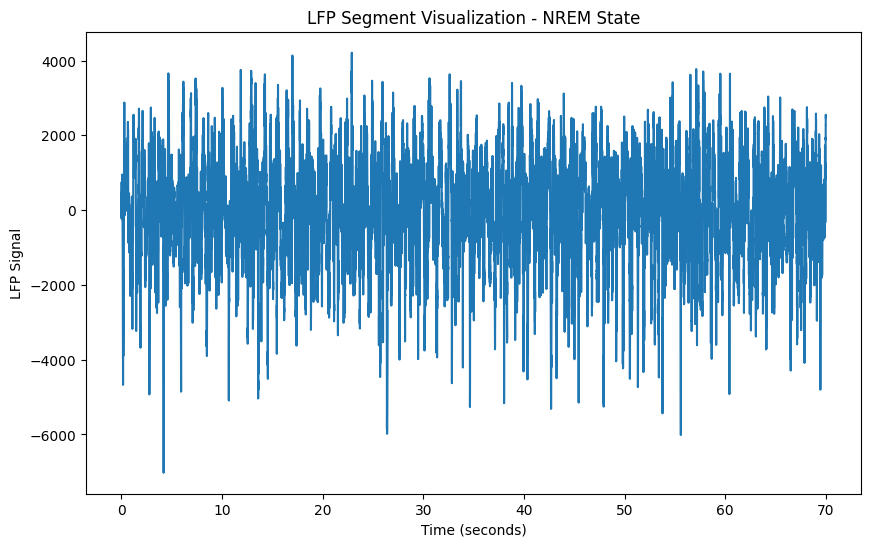

In [3]:
import matplotlib.pyplot as plt

state = 'NREM'  # The state you're interested in
segment_index = 2  # The segment index you want to visualize

# Check if the state and segment index are valid
if state in lfp and segment_index < segment_counts[state]:
    x = lfp[state][segment_index]
    t = np.arange(len(x)) / fs  # Time axis

    plt.figure(figsize=(10, 6))
    plt.plot(t, x)
    plt.xlabel('Time (seconds)')
    plt.ylabel('LFP Signal')
    plt.title(f'LFP Segment Visualization - {state} State')
    plt.show()
else:
    print(f"Data for state '{state}' with index {segment_index} is not available.")

In [4]:
# Ensure sampling_rate and clip_duration are defined correctly
sampling_rate = int(fs)  # Convert to integer if not already
clip_duration = 5  # Duration in seconds

# Calculate samples per clip and explicitly convert to integer
samples_per_clip = int(clip_duration * sampling_rate)

# Now, use this corrected `samples_per_clip` in your loop
clips = {state: [] for state in states}

for state in states:
    for segment in lfp[state]:
        num_clips = len(segment) // samples_per_clip

        for i in range(num_clips):
            start_sample = i * samples_per_clip
            end_sample = start_sample + samples_per_clip
            clip = segment[start_sample:end_sample]
            clips[state].append(clip)
        # ignoring partial clips that are not 5 seconds. opting to not pad them with zeros and use them for training
for state in clips:
    num_clips = len(clips[state])
    print(f"State: {state}, Number of 5-second clips: {num_clips}")


State: NREM, Number of 5-second clips: 330
State: WAKE, Number of 5-second clips: 577


Epoch 1/25 - Loss: 0.4287
Epoch 2/25 - Loss: 0.1917
Epoch 3/25 - Loss: 0.1475
Epoch 4/25 - Loss: 0.1179
Epoch 5/25 - Loss: 0.1070
Epoch 6/25 - Loss: 0.0898
Epoch 7/25 - Loss: 0.0737
Epoch 8/25 - Loss: 0.0678
Epoch 9/25 - Loss: 0.0632
Epoch 10/25 - Loss: 0.0504
Epoch 11/25 - Loss: 0.0445
Epoch 12/25 - Loss: 0.0383
Epoch 13/25 - Loss: 0.0371
Epoch 14/25 - Loss: 0.0319
Epoch 15/25 - Loss: 0.0299
Epoch 16/25 - Loss: 0.0246
Epoch 17/25 - Loss: 0.0217
Epoch 18/25 - Loss: 0.0197
Epoch 19/25 - Loss: 0.0167
Epoch 20/25 - Loss: 0.0184
Epoch 21/25 - Loss: 0.0153
Epoch 22/25 - Loss: 0.0143
Epoch 23/25 - Loss: 0.0124
Epoch 24/25 - Loss: 0.0115
Epoch 25/25 - Loss: 0.0115


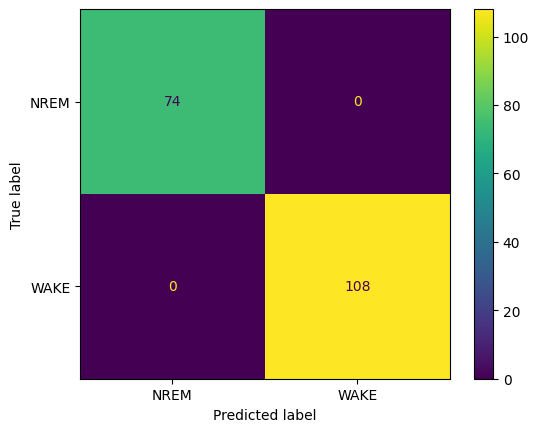

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from typing import List, Optional
from torch import Tensor


# Flatten the 5-second clips into 1D arrays if they are not already
X = np.array([clip.flatten() for state_clips in clips.values() for clip in state_clips])
# Create labels (0 for 'NREM', 1 for 'WAKE')
y = np.array([0]*len(clips['NREM']) + [1]*len(clips['WAKE']))

# Normalize the data
X_normalized = (X - X.mean(axis=0)) / X.std(axis=0)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors and create datasets
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class ConvNet(nn.Module):
    def __init__(self, in_channels: int = 1, hidden_dims: Optional[List[int]] = None, output_length: int = 2):
        super(ConvNet, self).__init__()
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 64, 32, 1]

        # Define convolutional layers
        self.layers = nn.ModuleList()
        for h_dim in hidden_dims:
            self.layers.append(
                nn.Sequential(
                    nn.Conv1d(in_channels, h_dim, kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm1d(h_dim),
                    nn.ReLU()
                )
            )
            in_channels = h_dim

        # Dummy variable for input size
        self.fc_in_features = None  # Will be determined dynamically in forward()

        # Define fully connected layer, the input features will be set later
        self.fc_final = nn.Linear(self.fc_in_features if self.fc_in_features else 1, output_length)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        # Dynamically determine input size for fully connected layer
        if self.fc_in_features is None:
            self.fc_in_features = x.nelement() // x.shape[0]  # Total elements divided by batch size
            self.fc_final = nn.Linear(self.fc_in_features, 2)  # Recreate the fc layer with correct size

        x = torch.flatten(x, 1)
        x = self.fc_final(x)
        return x


# Instantiate the model, loss function, and optimizer
model = ConvNet(in_channels=1, hidden_dims=[32, 64, 128, 64, 32], output_length=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print('Epoch {}/{} - Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_loss))
    return model

# Train the network
model = train_model(model, train_loader, criterion, optimizer, num_epochs=25)

# Validate the model
def validate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
    return all_labels, all_preds

# Run validation
labels, preds = validate_model(model, test_loader)

# Display confusion matrix
conf_matrix = confusion_matrix(labels, preds)
ConfusionMatrixDisplay(conf_matrix, display_labels=['NREM', 'WAKE']).plot()
plt.show()